<p align="center">
  <img src="Graphics/Episode XII.png" />
</p>

## (0) Probabilistic Planning & Reinforcement Learning

### (0.1) From Classical to Probabilistic Decision-Making

Up until now, all of the problems we've met involved actions and environments that were deterministic in nature, but in real life such cases aren't always true! For our final tutorial (which serves as enrichment, given that this material is beyond the scope of the course), let's explore methods to represent and solve decision-making problems where the environment and/or the actions available within it are **probabilistic** in nature. 

### (0.2) Learning Outcomes

In this tutorial, we will cover:
* How to model probabilistic decision-making problems with Markov decision processes (MDP)
* How to solve MDP's using the Bellman equation and dynamic programming methods
* How to use reinforcement learning approaches to solve probabilistic decision-making problems where the model is not explicitly given
* Some useful packages for representing and solving PP and RL problems, including OpenAI Gym and RDDLGym

### (0.3) Libraries

In [1]:
import gym, time
import numpy as np
import matplotlib.pyplot as plt

from Code import EnvSetup
from Code import DynamicProgramming as DP
from Code import PassiveRL as pRL

### (0.4) Disclaimer

While this tutorial is enrichment, it is still recommended viewing for those students who are curious about the topic or are undertaking final projects which involve probabilistic actions or require the use of OpenAI Gym for simulation. **Note:** The OpenAI Gym library *does not* work on the Windows Operating System!!! You'll need to run this notebook from a Linux OS in order to use the code that relies on Gym.

<p align="center">
  <img src="Graphics/RL.gif" width=500/>
</p>

## (1) Introduction to Probabilistic Planning

### (1.1) Motivation

To understand why things will change when we start to consider probabilities, let's examine the following problem (known as the Frozen Lake problem):
<p align="center">
  <img src="Graphics/FrozenLake.PNG" width=500/>
</p>

In this problem, there is a robot standing on a frozen lake which can be divided into 12 uniform squares. On one of the squares, there is an oil can which the robot would like to obtain, and it can reach this oil can by moving between squares one at a time. On a different square, there is a hole in the ice which the robot would like to avoid - if it falls in the hole, the robot's computers will freeze up and it'll never be able to reach the oil can (this signifies a failure).

At any given square, the robot can try to move in one of 4 directions: left, right, up, down. If moving in a certain direction would cause the robot to cross outside the boundaries of the lake, then it can't choose to move in that direction. For example, from the starting position (0,0), the robot can only move down or left. For now, we'll assume that all moves are deterministic (i.e. if we tell the robot to move down, then it will move down with 100% certainty as long is this is an allowed move).

Let's assume that the cost of moving between any two adjacent squares is just equal to one, and that the oil can square and the hole square are terminal states. Then, we can simply represent this problem as a graph and conduct a classical search on it in order to find the best path (in this case, best just means shortest). For example, we can represent the graph as follows:
<p align="center">
  <img src="Graphics/FrozenLake_Graph.PNG" width=500/>
</p>

Note that the first square (at 0,0) is marked I for initial state, the square at 1,1 representing the hole is marked H, and the square at 2,3 representing the oil can is marked G (for goal). If we move to H (any of the red arrows), then the robot will fall into the hole and fail to get the oil can, whereas if we move to G (any of the green arrows), then the robot will successfully obtain the oil can.

Let's denote the actions in this problem as follows: 0 = Left, 1 = Down, 2 = Right, and 3 = Up. It's clear that we can just use Breadth First-Search (where we first expand nodes with lower action index value, i.e. Down [1] before Right [2]) to easily find the shortest path for this problem. Assuming we don't revisit states during our search, the BFS tree created and the solution it obtains will look as follows:
<p align="center">
  <img src="Graphics/FrozenLake_BFS.png" width=700/>
</p>

Classical search and planning was sufficient to solve this problem when all of the actions were deterministic, but what happens if they become probabilistic? 

For the Frozen Lake problem, let's now say that the ice is quite slippery. If the robot tries to move in some direction, then it will succeed 60% of the time, while 40% of the time it will slip in one of the perpendicular directions. For example, if we try to move from down from the start position, then the robot will move down to state $S(1,0)$ with 60% probability and will move right to state $S(0,1)$ with 40% probability (it won't ever move left, since there is a boundary there). If both perpendicular directions are available, then the 40% probability is split evenly between both directions. For example, if we try to move right from state $S(1,2)$ then the robot will move right to state $S(1,3)$ with 60% probability, will move down to state $S(2,2)$ with 20% probability, and will move up to state $S(0,2)$ with 20% probability.

This new system for having probabilistic results of our actions for any given state is called a **transition model**, and we can formally define it for our problem now as follows:
$$
T(s,a,s') = P(s_{t+1}=s'|s_{t}=s,a_{t}=a)= \begin{cases}
1, & s\in\{G,H\} \; | \; s'=s \; \forall a \in A(s)\\
p, & s\in S \text{\textbackslash} \{G,H\} \; | \; s'=a(s)\\
\frac{1-p}{|A_{\perp}(s)|}, & s\in S \text{\textbackslash} \{G,H\} \; | \; s'=a_{\perp}(s)\; \forall  a_{\perp} \in A_{\perp}(s)
\end{cases}
$$

where $p$ is the success probability for moving in the desired direction (in our case 0.6) and $A_{\perp}(s)$ is the space of valid perpendicular actions for some state ($A_{\perp}(s) \subset A(s)$ and $a_{\perp}(s)\neq a(s)$).

In this case, our BFS solution is no longer necessarily suitable as a solution to the problem. What does that mean, exactly? Well, now we are longer guaranteed to even reach the goal state if we follow the plan given by BFS, let alone to reach it along the shortest path possible. Run the following code to simulate the robot trying to follow the BFS solution across 1000 episodes (each time the robot goes from the initial state to a terminal state, we call this an **episode**) - because the problem is now probabilistic in nature, we need a large number of trials to observe the statistical behavior of our solutions:

In [2]:
env = EnvSetup.EnvPrep(p=0.6)
EnvSetup.evaluate(env, agent='BFS')

----------------------------------------------
BFS agent successfully reached the goal in 321 out of 1000 episodes and received an average reward of -0.358 using this policy.

Policy:
 [['v' '>' 'v' 'v']
 ['v' 'H' 'v' 'v']
 ['>' '>' '>' 'G']]

BFS agent took an average of 7 steps to reach the goal.
----------------------------------------------


We see that the robot will only reach the goal in somewhere between 250 and 350 episodes (the rest of the times, it falls into the hole), when it follows the BFS plan. Actually, calling it a plan is now a misnomer since the actions are not determinstic - from now on, we will refer to solutions to probabilistic planning (PP) problems as **policies**. The policy an agent uses to solve a PP problem is a function $\pi(s)$ that returns an action that our agent should do for any state $s\in S$. For example, the code above printed the following policy that BFS would return:
```
[['v' '>' 'v' 'v']
 ['v' 'H' 'v' 'v']
 ['>' '>' '>' 'G']]
```
Here, the symbol located in slot $(i,j)$ shows the action that BFS recommends we take when we are in that slot. For example, if we are in the initial state ($I=S(0,0)$), then we should go down (`v`) according to BFS. Running BFS from all non-terminal states will produce this policy for us. Notice that the policy recommends an action solely based on the state we are in - it does not need to consider anything else. This is related to a property called the *Markov Property* which we will discuss soon. The terminal states are not assigned an action in the policy, since the episode always ends once a terminal state is reached (thus no more moves can be made).

Lastly, we see that even when the BFS agent does manage to reach the goal, it on average will need around 7 steps to do so (whereas the BFS solution for the classical case requires only 5 steps).

It should be clear now that probabilistic decision-making problems aren't as straightforward as their classical counterparts. It will thus be our goal to find a way to improve the performance of our policies, i.e. to find policies that allow us to reach desirable goal states more often. As a baseline, let's test a policy where ever action is just selected randomly from the set of valid actions in a given state:

In [3]:
EnvSetup.evaluate(env, agent='Random')

----------------------------------------------
Random agent successfully reached the goal in 62 out of 1000 episodes and received an average reward of -0.876 using this policy.

Random agent took an average of 10 steps to reach the goal.
----------------------------------------------


The random agent is clearly not a good choice, since it only reaches the goal in somewhere between 50 and 100 episodes. It also needs somewhere between 9 and 11 steps on average to reach the goal (when it succeeds it do so), and so the BFS policy still produces better results (despite being ignorant to the probabilistic nature of the problem). Let's try one more policy (the *optimal* policy - we will define optimality soon) on this problem, to see if there is in fact anything better than the BFS policy: 

In [4]:
EnvSetup.evaluate(env, agent='Optimal')

----------------------------------------------
Optimal agent successfully reached the goal in 485 out of 1000 episodes and received an average reward of -0.030 using this policy.

Policy:
 [['>' '>' '>' 'v']
 ['v' 'H' '>' 'v']
 ['>' '>' '>' 'G']]

Optimal agent took an average of 9 steps to reach the goal.
----------------------------------------------


Remarkably, we see that now we reach the goal successfully in 450-500 episodes! This is much better performance than BFS, though we should note that the average solution length is a bit longer than BFS (now it's around 9). This mysterious new policy looks as follows:
```
[['>' '>' '>' 'v']
 ['v' 'H' '>' 'v']
 ['>' '>' '>' 'G']]
```
We see that instead of always following the shortest path to the goal state, it actually tells the robot to try to get farther away from the hole before attempting to approach the goal (specificilly, notice that when the robot is in the states $S(0,0),S(0,2),S(1,2)$ it is now told to move right (`>`) by this policy, whereas the BFS policy told it to move down (`v`)). This is in fact the optimal policy for this problem, and we will soon learn how to obtain it ourselves from scratch.

What does optimal mean in this case though? Do we just want to find policies that produce the highest success rates? No, since we can have problems where the success rate is always 100% (imagine we just remove the hole from the Frozen Lake problem and replace it with a regular square) - we'll need to find a new metric for optimality!

#### (1.1.1) The OpenAI Gym Library

Before we move on, I'd like to go back to the code I used earlier to simulate the Frozen Lake problem. I was able to do so using a Python library called [OpenAI Gym](https://www.gymlibrary.dev/) (made by, you guessed it, OpenAI), usually just called Gym for short. This library is very popular in the field of probabilistic decision-making and reinforcement learning, since it provides a convenient way to model, solve, and simulate such problems in Python, as well as providing a catalog of pre-designed problems (such as the Frozen Lake and many Atari games) that users can easily test their algorithms on.

The core concept in the Gym library is the `Environment` class, which contains all the information needed to represent a probabilistic reasoning problem (all the states, actions, etc). To create an instance of the Frozen Lake problem's environment, for example, we will run the following commands:  

In [5]:
desc = ["SFFF", "FHFF", "FFFG"] # this just describes the map, S = initial state, H = hole, G = goal state, F = all other states
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=True) # The `env` object stores our environment, and can be dynamically interacted with
## the `is_slippery` parameter is just used to indicate that we want the probabilistic version of the Frozen Lake problem

EnvSetup.redefine_prob_model(env, prob=0.6) # this is a custom function I created to redefine the problem's transition model

Now that we have our environment initialized and stored in the `env` object, we can visualize its current state (which should just be the initial state for now - we'll use the `env.reset()` command to make sure of this) using the `env.render()` command:

In [6]:
env.reset()
print(env.s) # indicates the index of the current state, should be 0 for the initial state

env.render()

0

SFFF
FHFF
FFFG


We can use the command `env.step(action)` to try to apply the move `action` to our current state. The actions are passed to this function using the index corresponding to that action, which like before is: 0 = Left, 1 = Down, 2 = Right, and 3 = Up. Let's see we try to move right from the initial state, then we will pass 2 to the `step` function:

In [7]:
new_state, _, _, _ = env.step(2)
print(new_state)

env.render()

1
  (Right)
SFFF
FHFF
FFFG


We should see that our new state is either 1 (if the Right action succeeded, which happens 60% of the time) or 4 (if we slipped and did the Down action instead, which happens 40% of the time). That's it! To restart the environment (and thus start a new episode), we just run the `env.reset()` command again.

Our focus will be on methods for choosing which action to pass to the `step` function, depending on which state we're in. We'll want to construct some sort of `policy` map such that `policy(s)` $\rightarrow \{0,1,2,3\}$ (i.e. the policy returns an action given a state) for all non-terminal states $s$.

### (1.2) Markov Decision Processes

#### (1.2.1) The Markov Property

#### (1.2.2) Utility, Policy, & Quality

### (1.3) Bellman's Equation

#### (1.3.1) Bellman's Optimality Criterion

### (1.4) Dynamic Programming

#### (1.4.1) Value Iteration

##### (1.4.1.1) Code Example

In [8]:
V_opt, pi = DP.ValueIteration(env, policy_extract=True)
EnvSetup.evaluate(env, agent='Value Iteration', pi=pi)

print("\nFinal Value Vector:\n", np.reshape(V_opt,(3,4)))

----------------------------------------------
Value Iteration agent successfully reached the goal in 460 out of 1000 episodes and received an average reward of -0.080 using this policy.

Policy:
 [['>' '>' '>' 'v']
 ['v' 'H' '>' 'v']
 ['>' '>' '>' 'G']]

Value Iteration agent took an average of 9 steps to reach the goal.
----------------------------------------------

Final Value Vector:
 [[-0.0539541   0.19825443  0.99839047  0.99823756]
 [-0.43226705 -1.          0.99861984  0.99944794]
 [-0.053266    0.19940127  0.99944794  1.        ]]


In [9]:
tot_time = []
for _ in range(100):
    start_time = time.time()
    DP.ValueIteration(env, policy_extract=True)
    tot_time.append(time.time() - start_time)
print(f"Value Iteration took {np.mean(tot_time):.4f} seconds on average over 100 trials.")

Value Iteration took 0.0089 seconds on average over 100 trials.


#### (1.4.2) Policy Iteration

##### (1.4.2.1) Policy Evaluation

##### (1.4.2.2) Policy Extraction

##### (1.4.2.3) Policy Improvement

##### (1.4.2.4) Code Example

In [10]:
pi = DP.PolicyIteration(env)
EnvSetup.evaluate(env, agent='Policy Iteration', pi=pi)

----------------------------------------------
Policy Iteration agent successfully reached the goal in 475 out of 1000 episodes and received an average reward of -0.050 using this policy.

Policy:
 [['>' '>' '>' 'v']
 ['v' 'H' '>' 'v']
 ['>' '>' '>' 'G']]

Policy Iteration agent took an average of 8 steps to reach the goal.
----------------------------------------------


In [11]:
for _ in range(100):
    start_time = time.time()
    DP.PolicyIteration(env, gamma=1)
    tot_time.append(time.time() - start_time)
print(f"Policy Iteration took {np.mean(tot_time):.4f} seconds on average over 100 trials.")

Policy Iteration took 0.0079 seconds on average over 100 trials.


!pip install gym
!pip install gym[toy_text]

"""
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
"""

def argmax(env, V, pi, action,s, gamma):
    e = np.zeros(env.env.nA)
    for a in range(env.env.nA):                         # iterate for every action possible 
        q=0
        P = np.array(env.env.P[s][a])                   
        (x,y) = np.shape(P)                             # for Bellman Equation 
        
        for i in range(x):                              # iterate for every possible states
            s_= int(P[i][1])                            # S' - Sprime - possible succesor states
            p = P[i][0]                                 # Transition Probability P(s'|s,a) 
            if p <= 0.0:
                e[a] = -np.inf
                break                              
            r = P[i][2]                                 # Reward
            
            q += p*(r+gamma*V[s_])                      # calculate action_ value q(s|a)
            e[a] = q   
    m = np.argmax(e) 
    action[s]=m                                           # Take index which has maximum value 
    pi[s][m] = 1                                        # update pi(a|s) 

    return pi


def bellman_optimality_update(env, V, s, gamma):  # update the stae_value V[s] by taking action which maximizes current value
    if env.P[s][0][0][3] == True:
        V[s] = env.P[s][0][0][2]
        return V[s]

    pi = np.zeros((env.env.nS, env.env.nA))
    e = np.zeros(env.env.nA)                       
                                            # STEP1: Find 
    for a in range(env.env.nA):             
        q=0                                 # iterate for all possible action
        P = np.array(env.env.P[s][a])
        (x,y) = np.shape(P)
        
        for i in range(x):
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            q += p*(r+gamma*V[s_])
            e[a] = q
    
    m = np.argmax(e)
    pi[s][m] = 1
    
    value = 0
    for a in range(env.env.nA):
        u = 0
        P = np.array(env.env.P[s][a])
        (x,y) = np.shape(P)
        for i in range(x):
            
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            
            u += p*(r+gamma*V[s_])
            
        value += pi[s,a] * u
  
    V[s]=value
    return V[s]

def value_iteration(env, gamma, theta):
    V = np.zeros(env.env.nS)                              # initialize v(0) to arbitory value, my case "zeros"
    while True:
        delta = 0
        for s in range(env.env.nS):                       # iterate for all states
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)   # update state_value with bellman_optimality_update
            delta = max(delta, abs(v - V[s]))             # assign the change in value per iteration to delta 
        if delta < theta:                                       
            break                                       # if change gets to negligible 
                                                          # --> converged to optimal value         
    pi = np.zeros((env.env.nS, env.env.nA)) 
    action = np.zeros((env.env.nS))
    for s in range(env.env.nS):
        pi = argmax(env, V, pi,action, s, gamma)         # extract optimal policy using action value 
        
    return V, pi,action                                          # optimal value funtion, optimal policy

!pip install tools

desc = ["SFFF", "FHFF", "FFFG"]
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=True)
redefine_prob_model(env,prob=0.6)
env.reset()
#env.render()

gamma = 1
#theta = 0.001
theta = 0.000001

V, pi, action = value_iteration(env, gamma, theta)
print(V)

#import tools 
#tools.plot(V,pi)

a= np.reshape(action,(3,4))
print(a)                          # discrete action to take in given state

e=0
for i_episode in range(100):
    c = env.reset()
    for t in range(10000):
        c, reward, done, info = env.step(action[c])
        if done:
            if reward == 1:
                e += 1
            break
print(" agent succeeded to reach goal {} out of 100 Episodes using this policy ".format(e))
env.close()

## (2) Introduction to Reinforcement Learning

### (2.1) General Overview of RL Methods

#### (2.1.1) Passive vs. Active RL

#### (2.1.2) Model-Based vs. Model-Free Approaches

### (2.2) Passive RL

#### (2.2.1) Direct Utility (or Monte Carlo) Estimation

(Model-Free)

In [12]:
pi = [1,2,1,1,1,'H',1,1,2,2,2,'G']
num_episodes = 1000
V_mc = pRL.MC_Estimation(env, pi, num_episodes=num_episodes, every_time=True)
print("MC-Estimated Value Vector after", num_episodes, "episodes:\n", np.reshape(V_mc,(3,4)),"\n")

MC-Estimated Value Vector after 1000 episodes:
 [[-0.418      -0.22342733  0.34707904  0.80769231]
 [-0.5707196  -1.          0.32954545  0.81176471]
 [-0.25269978  0.0234375   0.67810026  1.        ]] 



In [13]:
#pRL.ConvergenceCheck(env,pi,method='MC',eps=10**-1)

In [14]:
#mc_error = pRL.Plot_MSEvEpisodes(env, pi, V_opt, method='MC')

#### (2.2.2) Temporal Difference Learning - TD(0)

(Model-Free)

In [15]:
pi = [1,2,1,1,1,'H',1,1,2,2,2,'G']
num_episodes = 1000
V_TD0 = pRL.TD0(env, pi, alpha=0.5, gamma=1, num_episodes=num_episodes)
print("TD0-Estimated Value Vector after", num_episodes, "episodes:\n", np.reshape(V_TD0,(3,4)),"\n")

TD0-Estimated Value Vector after 1000 episodes:
 [[-0.2972665   0.39679572  0.18448517  0.78528676]
 [-0.82759232 -1.          0.33014004  0.91049351]
 [-0.22051668  0.28338958  0.88545613  1.        ]] 



In [16]:
#pRL.ConvergenceCheck(env,pi,method='TD0',alpha=0.1)

In [17]:
#td0_error = pRL.Plot_MSEvEpisodes(env, pi, V_opt, method='TD0', alpha=0.1)

In [18]:
pi = [2,2,2,1,1,'H',2,1,2,2,2,'G']
alphas = np.linspace(0.01,1,100)
error = np.zeros_like(alphas)

for idx, a in enumerate(alphas):
    V_TD0 = pRL.TD0(env, pi, alpha=a, num_episodes=1000)
    error[idx] = np.linalg.norm(np.subtract(V_TD0,V_opt),ord=2) / len(error)

!pip install matplotlib

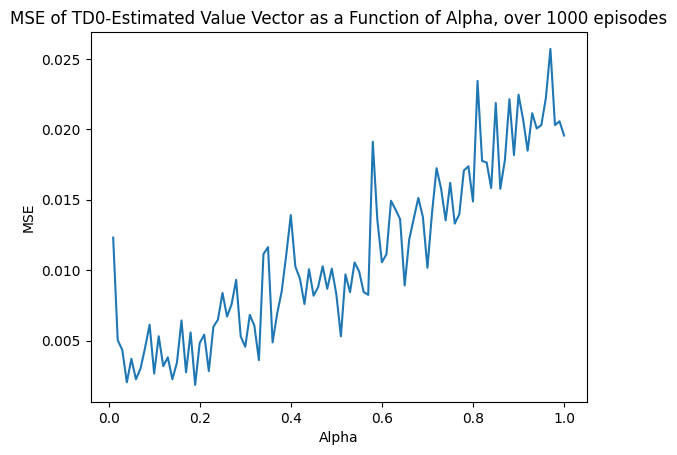

In [19]:
plt.plot(alphas,error)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE of TD0-Estimated Value Vector as a Function of Alpha, over 1000 episodes');

In [20]:
pi = [2,2,2,1,1,'H',2,1,2,2,2,'G']
alphas = [0.01,0.02,0.03,0.04,0.05,0.1,0.15]
episodes = np.linspace(10,1000,10,dtype=int)
error = np.zeros((len(alphas),len(episodes)))

#for i, a in enumerate(alphas):
#    for j, e in enumerate(episodes):
#        res = []
#        for _ in range(10):
#            V_TD0 = pRL.TD0(env, pi, alpha=a, num_episodes=e)
#            res.append(np.linalg.norm(np.subtract(V_TD0,V_opt),ord=2) / len(episodes))
#        error[i][j] = np.mean(res)

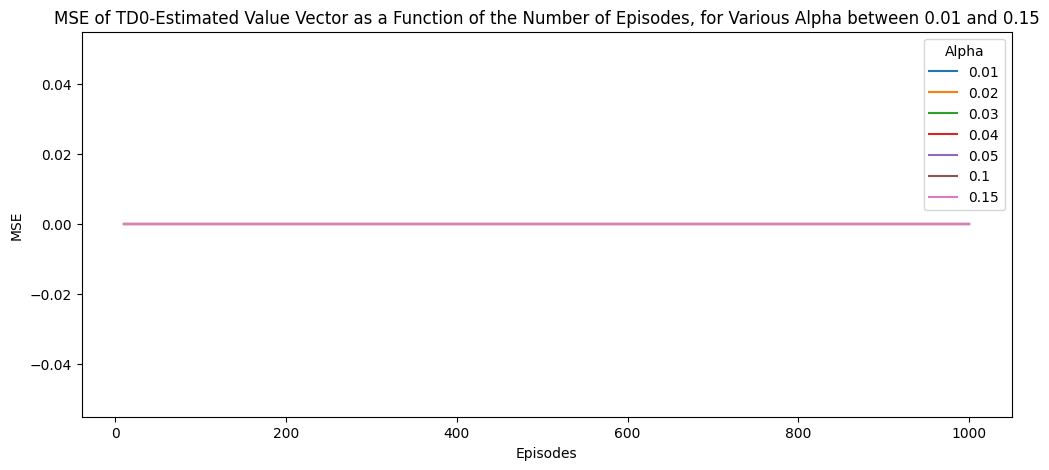

In [21]:
plt.rcParams["figure.figsize"] = (12,5)
for i, a in enumerate(alphas):
    plt.plot(episodes,error[i], label=str(a))
plt.legend(title='Alpha')
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.title('MSE of TD0-Estimated Value Vector as a Function of the Number of Episodes, for Various Alpha between 0.01 and 0.15');

In [22]:
alphas = [0.01,0.1,0.25,0.5,0.75,1]
episodes = np.linspace(10,1000,10,dtype=int)
error = np.zeros((len(alphas),len(episodes)))

#for i, a in enumerate(alphas):
#    for j, e in enumerate(episodes):
#        res = []
#        for _ in range(10):
#            V_TD0 = pRL.TD0(env, pi, alpha=a, num_episodes=e)
#            res.append(np.linalg.norm(np.subtract(V_TD0,V_opt),ord=2) / len(episodes))
#        error[i][j] = np.mean(res)

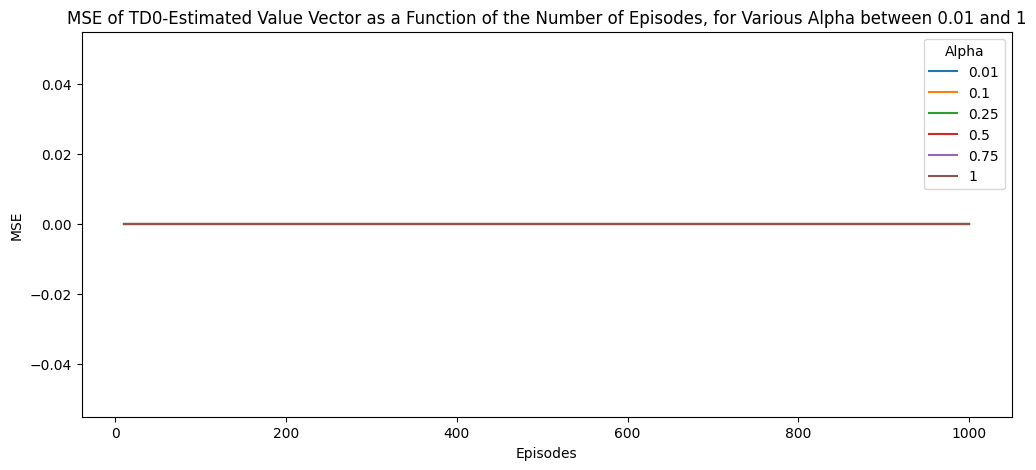

In [23]:
plt.rcParams["figure.figsize"] = (12,5)
for i, a in enumerate(alphas):
    plt.plot(episodes,error[i], label=str(a))
plt.legend(title='Alpha')
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.title('MSE of TD0-Estimated Value Vector as a Function of the Number of Episodes, for Various Alpha between 0.01 and 1');

In [24]:
episodes = np.linspace(10,1000,10,dtype=int)
error = np.zeros_like(episodes,dtype=float)

for i, e in enumerate(episodes):
    res = []
    for _ in range(100):
        V_TD0 = pRL.TD0(env, pi, num_episodes=e, adaptive=True)
        res.append(np.linalg.norm(np.subtract(V_TD0,V_opt),ord=2) / len(episodes))
    error[i] = np.mean(res)

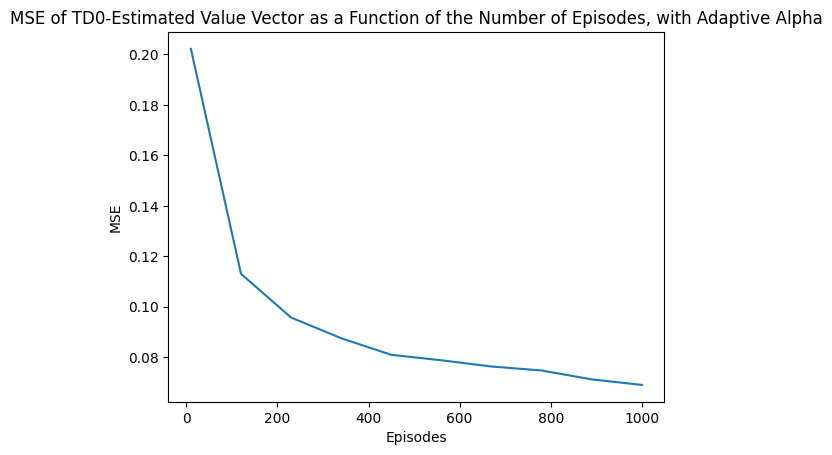

In [25]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.plot(episodes,error)
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.title('MSE of TD0-Estimated Value Vector as a Function of the Number of Episodes, with Adaptive Alpha');

#### (2.2.3) Adaptive Dynamic Programming (ADP)

(Model-Based)

In [26]:
pi = [2,2,2,1,1,'H',2,1,2,2,2,'G']
num_episodes = 1000

T,R = pRL.ADP(env,pi,num_episodes=num_episodes)
V_adp = pRL.ADP_PolicyEval(T, R, pi, gamma=1, theta=10**-3)

print("ADP-Estimated Value Vector after", num_episodes, "episodes:\n", np.reshape(V_adp,(3,4)),"\n")

ADP-Estimated Value Vector after 1000 episodes:
 [[-0.03337953  0.22192044  0.99834906  0.99899502]
 [-0.46271864 -1.          0.99920144  0.99939518]
 [-0.1020523   0.12328419  0.99944586  1.        ]] 



In [27]:
#pRL.ConvergenceCheck(env,pi,method='ADP',eps=10**-1)

In [28]:
#adp_error = pRL.Plot_MSEvEpisodes(env, pi, V_opt, method='ADP')

#### (2.2.4) Empirical Comparison of Passive RL Approaches

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


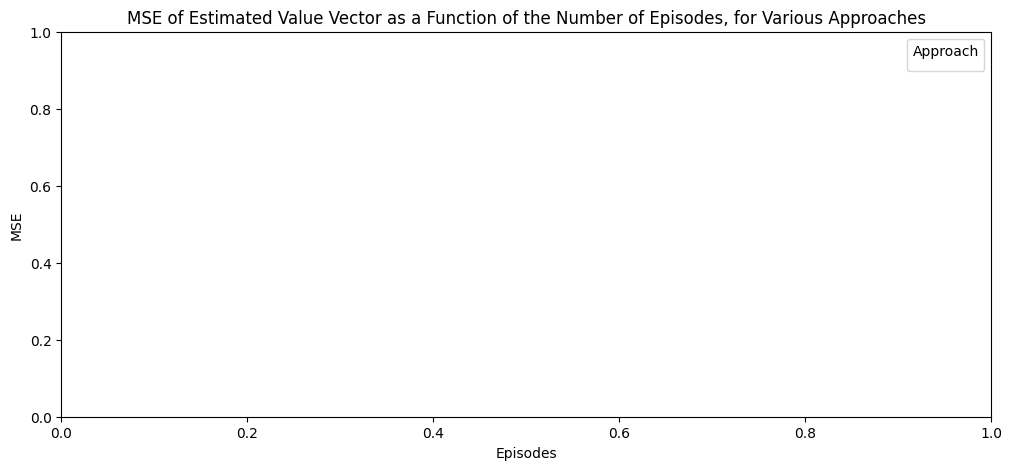

In [29]:
episodes = np.linspace(10,1000,10,dtype=int)

plt.rcParams["figure.figsize"] = (12,5)
#plt.plot(episodes, mc_error, label='Monte Carlo')
#plt.plot(episodes, adp_error, label='Adaptive DP')
#plt.plot(episodes, td0_error, label='TD0, alpha=0.1')

plt.legend(title='Approach')
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.title('MSE of Estimated Value Vector as a Function of the Number of Episodes, for Various Approaches');

### (2.3) Active RL

#### (2.3.1) ADP-Based Active RL

(Model-Based)

#### (2.3.2) SARSA (TD Learning-Based Active RL)

(Model-Based)

<p align="center">
  <img src="Graphics/SARSA.PNG" width=600/>
</p>

In [176]:
liste = [1,0,-np.inf]

valid = [i for i in range(len(liste)) if liste[i] > -np.inf]

#valid = np.argwhere(list != -np.inf)
#print(list[list != 0])
print(valid)

[0, 1]


In [231]:
def Init_Q(env):
    Q_0 = [[-np.inf for _ in range(env.nA)] for _ in range(env.nS)] # initialize the quality vector arbitrarily, ensuring that Q=0 for all terminal states
    allowable_actions = [(1,2),(0,1,2),(0,1,2),(0,1),(1,2,3),'H',(0,1,2,3),(0,1,3),(2,3),(0,2,3),(0,2,3),'G']
    
    for q in range(len(Q_0)):
        if allowable_actions[q]=='H' or allowable_actions[q]=='G':
            Q_0[q] = [0]
        else:
            for a in allowable_actions[q]:
                Q_0[q][a] = 0
    return Q_0

def SARSA(env, alpha=0.5, gamma=1, epsilon=0.5, num_episodes=100, adaptive=False, decay=0.01):
    Q = Init_Q(env)

    for e in range(num_episodes):
        s = env.reset() # start a new episode, assume the initial state isn't terminal
        a = np.argmax(Q[s]) # choose the action that maximizes Q (greedy)
        
        done = False
        while not done:
            new_s, R, done, _ = env.step(a)

            exp_exp_tradeoff = np.random.uniform(0,1)
            if exp_exp_tradeoff > epsilon: # exploitation
                new_a = np.argmax(Q[new_s]) # choose the action that maximizes Q (greedy)
            else: # exploration
                valid = [i for i in range(len(Q[new_s])) if Q[new_s][i] > -np.inf]
                new_a = np.random.choice(valid) # choose random valid action
                
            if done:
                Q[s][a] += alpha*(R - Q[s][a]) # TD step for terminal states
            else:
                Q[s][a] += alpha*(R + gamma*Q[new_s][new_a] - Q[s][a]) # TD step for non-terminal states
            
            s = new_s; a = new_a

        if adaptive:
            epsilon = np.exp(-decay*e)
            #print(epsilon) 
    return Q

def PolicyExtraction(Q):
    pi = [None]*len(Q)
    for s in range(len(Q)):
        pi[s] = np.argmax(Q[s])
    pi[5] = 'H'; pi[11] = 'G' 
    return pi

In [232]:
Q = SARSA(env, alpha=0.2, gamma=1, epsilon=0.5, num_episodes=10000, adaptive=True, decay=0.01)
print(Q)

[[-inf, -0.7111695624058635, 0.0072447472460813525, -inf], [-0.8114656844687369, -0.8802866212677739, 0.04606513661336231, -inf], [0.2556853108365427, 0.28764894796230994, 0.9999999999999991, -inf], [0.6421464522638518, 0.9999999999999993, -inf, -inf], [-inf, -0.2896223428544613, -0.9357804096598438, -0.9418701589115275], [-0.9999999999999998], [-0.28172873611101446, 0.25510822008608575, 0.9999999999999993, 0.18338316066435967], [0.7166665594204722, 0.9999999999999996, -inf, 0.2868145635426223], [-inf, -inf, 0.3235037678815693, -0.7679350232982779], [-0.7944646055779399, -inf, 0.26200614826111707, -0.7716275270580396], [-0.09366917485745829, -inf, 0.9999999999999996, 0.13657287230187254], [0.9999999999999998]]


In [233]:
pi = PolicyExtraction(Q)
EnvSetup.show_policy(pi)

Policy:
 [['>' '>' '>' 'v']
 ['v' 'H' '>' 'v']
 ['>' '>' '>' 'G']]


"""
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
"""

#### (2.3.3) Q Learning

(Model-Free)

<p align="center">
  <img src="Graphics/QLearning.PNG" width=600/>
</p>

In [234]:
def QLearning(env, alpha=0.5, gamma=1, epsilon=0.5, num_episodes=100, adaptive=False, decay=0.01):
    Q = Init_Q(env)
    for _ in range(num_episodes):
        s = env.reset() # start a new episode, assume the initial state isn't terminal
        done = False
        while not done:

            exp_exp_tradeoff = np.random.uniform(0,1)
            if exp_exp_tradeoff > epsilon: # exploitation
                a = np.argmax(Q[s]) # choose the action that maximizes Q (greedy)
            else: # exploration
                valid = [i for i in range(len(Q[s])) if Q[s][i] > -np.inf]
                a = np.random.choice(valid) # choose random valid action

            new_s, R, done, _ = env.step(a)
                
            if done:
                Q[s][a] += alpha*(R - Q[s][a]) # Q Learning step for terminal states
            else:
                Q[s][a] += alpha*(R + gamma*np.max(Q[new_s]) - Q[s][a]) # Q Learning step for non-terminal states
            
            s = new_s

            if adaptive:
                epsilon = np.exp(-decay*e)
                #print(epsilon) 
    return Q

In [241]:
Q = QLearning(env, alpha=0.2, gamma=1, epsilon=0.5, num_episodes=10000, adaptive=True, decay=0.01)
print(Q)

[[-inf, -0.3750989681902216, -0.7606114603547802, -inf], [-0.8628581891015933, -0.8669279577668699, 0.25508234637099025, -inf], [-0.04943607302538065, 0.11372785834207852, 0.9999999999999991, -inf], [0.9999999999999993, 0.19898088767182978, -inf, -inf], [-inf, -0.7018141568318623, -0.9530821661541649, -0.9435917676635275], [-0.9999999999999998], [-0.16644556800000002, -0.19998638870532315, 0.9999999999999993, 0], [0.9999999999999996, 0, -inf, 0], [-inf, -inf, -0.023315308334789994, -0.8025030459677158], [-0.8538880748421791, -inf, -0.4685043193462214, -0.84026357935513], [-0.003784808496318846, -inf, 0.9999999999999996, 0], [0.9999999999999998]]


In [242]:
pi = PolicyExtraction(Q)
EnvSetup.show_policy(pi)

Policy:
 [['v' '>' '>' '<']
 ['v' 'H' '>' '<']
 ['>' '>' '>' 'G']]


## (3) RDDLGym for Planning

## (4) Conclusion

In this tutorial, we:
* Introduced the basic concepts of probabilistic planning and reinforcement learning
* Learned how to code basic PP and RL problems using AI Gym and RDDLGym

This was the last tutorial for the semester, all that's left now is for you to do homeworks #3 and 4 along with your final projects. Thank you guys so much for being an awesome class, and I wish you all the best for your futures! May the force be with you.

#### ***Credit:** This tutorial was written by Yotam Granov, Winter 2022.*

### **References**

[1] R. Sutton & A. Barto. ["Reinforcement Learning: An Introduction (2nd Edition)"](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf), 2015.